In [65]:
import trimesh
import matplotlib.pyplot as plt
import cv2

import numpy as np

In [66]:
texture_hair = cv2.imread('/workspace/DECA/third_parties/align-hair/hair_texture_origin.png')
texture_hair = cv2.cvtColor(texture_hair, cv2.COLOR_BGR2RGB)

with open('hair_mm_origin.obj') as f:
    data = f.read().splitlines()

    obj = {}

    for line in data:
        t, *x = line.split()
        if t == '#':
            continue

        if t in obj:
            obj[t].append(x)
        else:
            obj[t] = [x, ]
H, W, C = texture_hair.shape

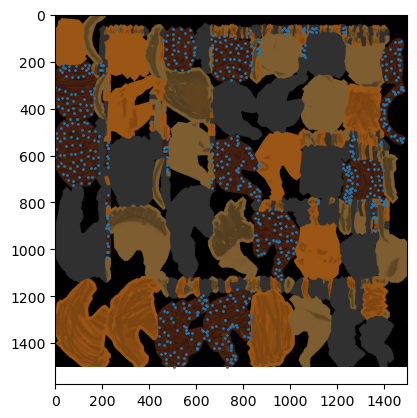

In [67]:
mesh_uv = np.array(obj['vt'])
mesh_uv = mesh_uv.astype(np.float64)
uv = mesh_uv.copy()
uv[:,1] = 1 - uv[:,1]

uv[:,0] *= W
uv[:,1] *= H


plt.imshow(texture_hair)
plt.scatter(uv[:,0], uv[:, 1], s=1)

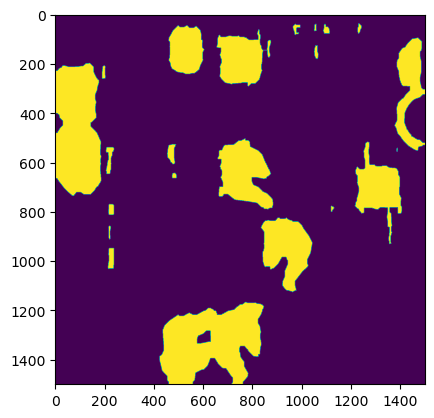

In [68]:
hsv = cv2.cvtColor(texture_hair, cv2.COLOR_RGB2HSV)
uv = uv.astype(np.uint8)

hair_color = hsv[uv[0, 0], uv[0, 1],:]
delta = np.ones((3,))  * 15
mask = cv2.inRange(hsv, hair_color - delta, hair_color + delta)

kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=8)

plt.imshow(mask)

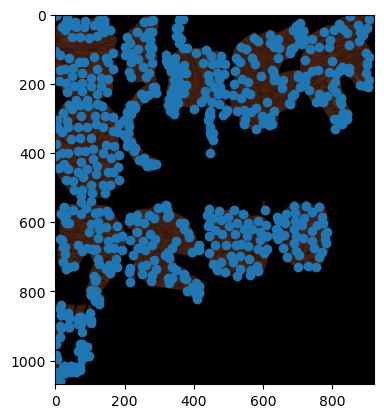

True

In [69]:
contours, hier = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[-1],reverse=True)
max_h = cv2.boundingRect(max(contours, key=lambda c: cv2.boundingRect(c)[-1]))[-1]
max_w = cv2.boundingRect(max(contours, key=lambda c: cv2.boundingRect(c)[-2]))[-2]

img_uv = mesh_uv.copy()
uv_re_tex = img_uv.copy()

img_uv[:,1] = 1 - img_uv[:,1]
img_uv[:,0] *= W
img_uv[:,1] *= H

img_uv = img_uv.astype(np.int16)
img_uv[img_uv == 1500] = 1499

re_tex_size = (max_h * 2, max_w * len(contours), 3)
re_tex = np.zeros(re_tex_size)

max_x = 0
max_y = 0
cur_x = 0
cur_y = 0

num_con = len(contours)

for i, con in enumerate(contours):
    src_patch_mask = np.zeros((H,W))

    cv2.drawContours(src_patch_mask, contours, i, 1, -1)
    src_patch_mask = src_patch_mask * mask
    x, y, w, h = cv2.boundingRect(con)
    
    M = np.array([[1, 0, -x + cur_x], [0,1, -y + cur_y]],dtype=np.float64)

    dest_patch_mask = cv2.warpAffine(src_patch_mask, M, (max_w * len(contours), max_h * 2))
    
    src_patch_mask = src_patch_mask.astype(bool)
    dest_patch_mask = dest_patch_mask.astype(bool)

    patch_idx = src_patch_mask[img_uv[:,1], img_uv[:,0]]

    uv_re_tex[patch_idx] = img_uv[patch_idx] + np.array([-x + cur_x, -y + cur_y])
    
    re_tex[dest_patch_mask] = hsv[src_patch_mask]

    cur_x += w
    max_y = max(h, max_y)
    
    if i %  (num_con // 6) == (num_con // 6) - 1:
        max_x = max(max_x, cur_x)
        cur_y += max_y
        max_y = 0
        cur_x = 0
 
re_tex = re_tex[:cur_y, :max_x].astype(np.uint8)

plt.imshow(cv2.cvtColor(re_tex, cv2.COLOR_HSV2RGB))
plt.scatter(uv_re_tex[:,0],uv_re_tex[:,1])
plt.show()
uv_re_tex[:,1] /= cur_y
uv_re_tex[:,0] /= max_x 

uv_re_tex[:, 1] = 1 - uv_re_tex[:,1]

with open('hair_mm.obj', 'wt') as f:
    f.write('mtllib material.mtl\n')
    f.write('usemtl material_0\n')

    for x,y,z in obj['v']:
        f.write(f'v {x} {y} {z}\n')
    
    for x,y,z in obj['vn']:
        f.write(f'vn {x} {y} {z}\n')

    for u,v in uv_re_tex:
        f.write(f'vt {u} {v}\n')

    for face in obj['f']:
        v1, v2, v3 = face
        f.write(f'f {v1} {v2} {v3}\n')

re_tex = cv2.resize(re_tex, (512, 512))
cv2.imwrite('hair_texture.png', cv2.cvtColor(re_tex, cv2.COLOR_HSV2BGR))
cv2.imwrite('material_0.png', cv2.cvtColor(re_tex, cv2.COLOR_HSV2BGR))

True

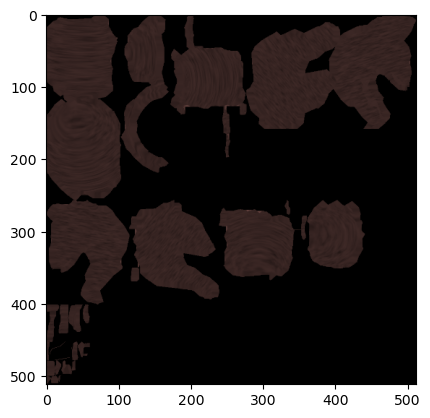

In [70]:
hair_tex = cv2.imread('hair_texture.png')

tex_mask = cv2.inRange(hair_tex, 0,1)

tex_mask = 255 - tex_mask

tex_mask = (tex_mask // 255).astype(bool)

hsv = cv2.cvtColor(hair_tex, cv2.COLOR_BGR2HSV)
hsv = hsv.astype(np.float64)
v = hsv[tex_mask, 2]
mean_v = v.mean()

d_v = (v - mean_v).astype(np.float64) * 0.5

target_color = np.array([[[3,94,54]]]) 

hsv[tex_mask] = target_color
hsv[tex_mask,2] += d_v

hsv[hsv[:,:,2] < 0] = 0
hsv = hsv.astype(np.uint8)
plt.imshow(cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB))

cv2.imwrite('hair_texture_color.png', cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR))